In [3]:
%matplotlib inline

import pickle as pkl
import os

import statsmodels.formula.api as smf
import seaborn as sns
import pandas as pd
import numpy as np

np.random.seed(123)

# Lee (2008)

We study the effect of incumbency on the next election.

In [4]:
df_base = pd.read_csv('../../datasets/processed/msc/house.csv')

## What are the basic characteristics of the dataset?

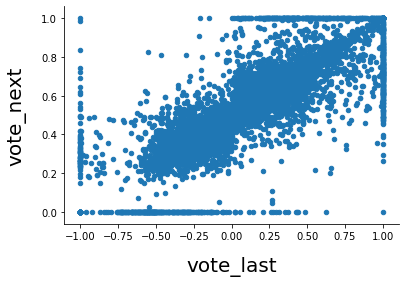

In [5]:
df_base['D'] = df_base.vote_last > 0
df_base.plot.scatter(x=0, y=1)

/home/peisenha/.local/share/anaconda3/envs/teaching_microeconometrics/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/peisenha/.local/share/anaconda3/envs/teaching_microeconometrics/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/peisenha/.local/share/anaconda3/envs/teaching_microeconometrics/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

,vote_last,vote_last_2,vote_last_3,vote_last_4
0,-0.500000,0.250000,-1.250000e-01,6.250000e-02
1,-0.494949,0.244975,-1.212503e-01,6.001275e-02
2,-0.489899,0.240001,-1.175763e-01,5.760049e-02
3,-0.484848,0.235078,-1.139772e-01,5.526169e-02
4,-0.479798,0.230206,-1.104524e-01,5.299485e-02
5,-0.474747,0.225385,-1.070010e-01,5.079847e-02
6,-0.469697,0.220615,-1.036223e-01,4.867109e-02
7,-0.464646,0.215896,-1.003155e-01,4.661123e-02
8,-0.459596,0.211228,-9.707974e-02,4.461746e-02
9,-0.454545,0.206612,-9.391435e-02,4.268834e-02


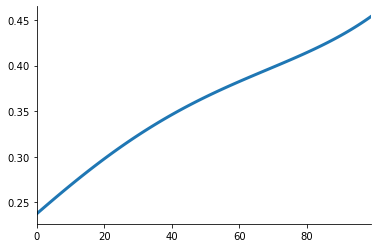

In [45]:
df_repu = df_base[df_base.vote_last < 0.0]
df_demo = df_base[df_base.vote_last > 0.0]

df = df_repu
df['vote_last_2'] = df['vote_last'] ** 2
df['vote_last_3'] = df['vote_last'] ** 3
df['vote_last_4'] = df['vote_last'] ** 4

df_grid = pd.DataFrame(np.linspace(-0.5, 0.0, 100), columns=['vote_last'])

df_grid['vote_last_2'] = df_grid['vote_last'] ** 2
df_grid['vote_last_3'] = df_grid['vote_last'] ** 3
df_grid['vote_last_4'] = df_grid['vote_last'] ** 4

rslt = smf.ols(formula='vote_next ~ vote_last + vote_last_2 + vote_last_3 + vote_last_4', data=df).fit()
rslt.summary()
rslt.predict(df_grid).plot()
df_grid

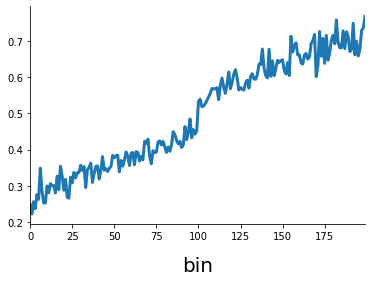

In [196]:
df = df_base.copy()
df['bin'] = pd.cut(df_base.vote_last, 200, labels=False)
df.groupby('bin')['vote_next'].mean().plot()

In [126]:
before_cutoff = df.groupby('bin')['vote_next'].mean()[99]
after_cutoff = df.groupby('bin')['vote_next'].mean()[100]

print('Treatment Effect: {:5.3f}'.format(after_cutoff - before_cutoff))

Treatment Effect: 0.081


## How does the estimated treatment effect depend on the choice of the bin width?

In [125]:
for num_bins in [100, 200]:
    df = df_base.copy(deep=True) 
    df['bin'] = pd.cut(df_base.vote_last, num_bins, labels=False)
    info = df.groupby('bin')['vote_next'].mean() 
    lower = (num_bins / 2) - 1
    effect = info[lower + 1] - info[lower]
    print(' Number of bins: {:}, Effect {:5.2f}%'.format(num_bins, effect * 100))

 Number of bins: 100, Effect  8.84%
 Number of bins: 200, Effect  8.10%


## Regression 

In [132]:
df['D'] = df.vote_last > 0
df.head()

,vote_last,vote_next,bin,D
0,0.1049,0.5810,120,True
1,0.1393,0.4611,127,True
2,-0.0736,0.5434,85,False
3,0.0868,0.5846,117,True
4,0.3994,0.5803,179,True


### Pooled regression

In [201]:
rslt = smf.ols(formula='vote_next ~ vote_last + D', data=df_base).fit()
print(rslt.summary())

                            OLS Regression Results                            
Dep. Variable:              vote_next   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.551
Method:                 Least Squares   F-statistic:                     3007.
Date:                Fri, 31 May 2019   Prob (F-statistic):               0.00
Time:                        16:13:30   Log-Likelihood:                 3230.0
No. Observations:                4900   AIC:                            -6454.
Df Residuals:                    4897   BIC:                            -6434.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4531      0.004    119.241      0.0

### Local linear regression

In [175]:
for h in [0.3, 0.2, 0.1, 0.05, 0.01]:
    df = df_base[df_base.vote_last.between(-h, h)]
    formula = 'vote_next ~ D + vote_last + D * vote_last'
    rslt = smf.ols(formula=formula, data=df).fit()
    info = [h, rslt.params[1] * 100, rslt.pvalues[1]]
    print(' Bandwidth: {:>4}   Effect {:5.3f}%    pvalue {:5.3f}'.format(*info))

 Bandwidth:  0.3   Effect 8.318%    pvalue 0.000
 Bandwidth:  0.2   Effect 7.818%    pvalue 0.000
 Bandwidth:  0.1   Effect 6.058%    pvalue 0.000
 Bandwidth: 0.05   Effect 4.870%    pvalue 0.010
 Bandwidth: 0.01   Effect 9.585%    pvalue 0.001
